In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Calibration
## Estimation of parameters for constrained distributions

Apply a doubly constrained gravity model with composite cost from the network model (i.e. logsum of mode choice utility) as deterrence matrix. Zone production and attraction (trip generation) is determined elsewhere.

$T_{ij} = P_i * A_j * f(c_{ij})$

$f(c_{ij}) = ?$

Follow Poisson fitting to determine cost function parameters. Given $N$ observations $n_{ij}$ (number of trips per OD pair), the likelyhood becomes

$p(\{n_{ij}\}| P_i, A_j, f(c_{ij})) = \prod_{i,j \in N} \frac{exp(c*\lambda)*(c*\lambda)^{n_{ij}}}{n_{ij}!}$

$\lambda = T_{ij} = P_i * A_j * f(c_{ij})$

$c = \frac{\sum_{i,j \in N}n_{ij}}{T}$

With $P_i, A_j$ given, just divide observed OD matrix into distance bins and determine the value of $f(c_{ij})$ for each bin. Choose a suitable functional form and parameters for $f(c_{ij})$. This is basically a trip length distribution fitting.

Good introduction to methods can be found here: https://ocw.tudelft.nl/wp-content/uploads/2.2-Trip-distribution.pdf

In [3]:
input_path = '../input/'
model_path = '../model/' + scenario + '/'
output_path = '../output/'

## Load data

In [4]:
cols = ['mode_model', 'purpose_model', 'purpose2', 'car_avail', 'length', 'origin', 'destination', 'P_ID', 'W_GEW']
trips = pd.read_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv', usecols=cols)
len(trips)

254876

In [5]:
trips['segment'] = trips['purpose_model'] + trips['car_avail'].map({0: '_no_car', 1: '_car', 9: '_no_car'})

In [6]:
# Composite cost
cc = pd.read_csv(output_path + 'base' + '/mode_choice_od_composite_cost.csv')
cc.set_index(['origin', 'destination'], inplace=True)
cc.sort_index(inplace=True)
cc.clip(lower=0.01, inplace=True)

In [7]:
# merge
cc.columns.name = 'segment'
trips = trips.merge(cc.stack().rename('cc').to_frame(),
                    how='left', left_on=['origin', 'destination', 'segment'], right_index=True)

In [8]:
# inner-zonal cc
inner = pd.read_csv(input_path + 'inner-zonal_cc.csv', index_col=0)
inner.index.name = 'origin'
inner.columns.name = 'segment'
trips = trips.merge(inner.stack().rename('inner_cc').to_frame(),
                    how='left', left_on=['origin', 'segment'], right_index=True)

segment
accompany_car         Axes(0.125,0.11;0.775x0.77)
accompany_no_car      Axes(0.125,0.11;0.775x0.77)
business_car          Axes(0.125,0.11;0.775x0.77)
business_no_car       Axes(0.125,0.11;0.775x0.77)
buy/execute_car       Axes(0.125,0.11;0.775x0.77)
buy/execute_no_car    Axes(0.125,0.11;0.775x0.77)
commuting_car         Axes(0.125,0.11;0.775x0.77)
commuting_no_car      Axes(0.125,0.11;0.775x0.77)
education_car         Axes(0.125,0.11;0.775x0.77)
education_no_car      Axes(0.125,0.11;0.775x0.77)
leisure_car           Axes(0.125,0.11;0.775x0.77)
leisure_no_car        Axes(0.125,0.11;0.775x0.77)
Name: inner_cc, dtype: object

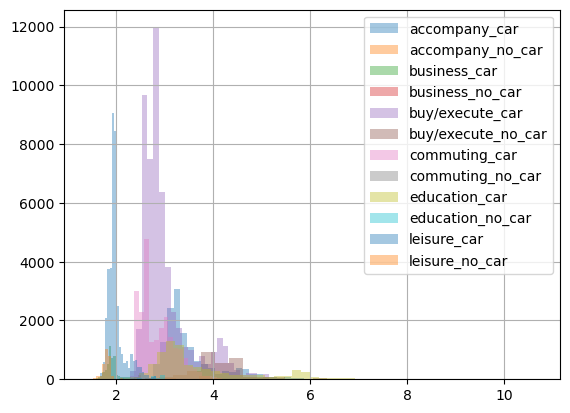

In [9]:
trips.loc[trips['origin']==trips['destination']
         ].groupby('segment')['inner_cc'].hist(bins=30, alpha=.4, legend=True)

In [10]:
#bins = [-1, 5, 10, 15, 20, 30, 40, 50, 70, 100, 200, 500, 1000]
bins = [-1] + list(range(5, 100, 5)) + list(range(100, 300, 50)) + [300, 400, 500, 750, 1000]
trips['bin'] = pd.cut(trips['length'], bins=bins, labels=bins[1:])
trips = trips.loc[trips['bin'].notna()]
trips['bin'] = trips['bin'].astype(int)
len(trips)

254876

In [11]:
# Cleanse
trips = trips.loc[~((trips['inner_cc'].isna()) & (trips['origin']==trips['destination']))]
trips = trips.loc[~((trips['cc'].isna()) & (trips['origin']!=trips['destination']))]
trips['cc'] = trips['cc'].fillna(trips['inner_cc'])
trips = trips.loc[~((trips['bin']>20) & (trips['origin']==trips['destination']))]
len(trips)

251795

In [12]:
# Create CC+distance metric
trips['cc_dist'] = trips['cc'] + trips['length'] / 10

In [13]:
# Cut cc into bins
dist = pd.read_csv(output_path + 'distances_centroids.csv', index_col=['origin', 'destination'])
cc = cc.merge(dist, right_index=True, left_index=True, how='left')
cc['bin'] = pd.cut(cc['length'], bins=bins, labels=bins[1:])
cc = cc.loc[cc['bin'].notna()]
cc['bin'] = cc['bin'].astype(int)

## Distance fitting

In [14]:
segments = sorted(list(set(trips['segment'])))
purposes = [s.split('_')[0] for s in segments][::2]

Text(0, 0.5, 'with car')

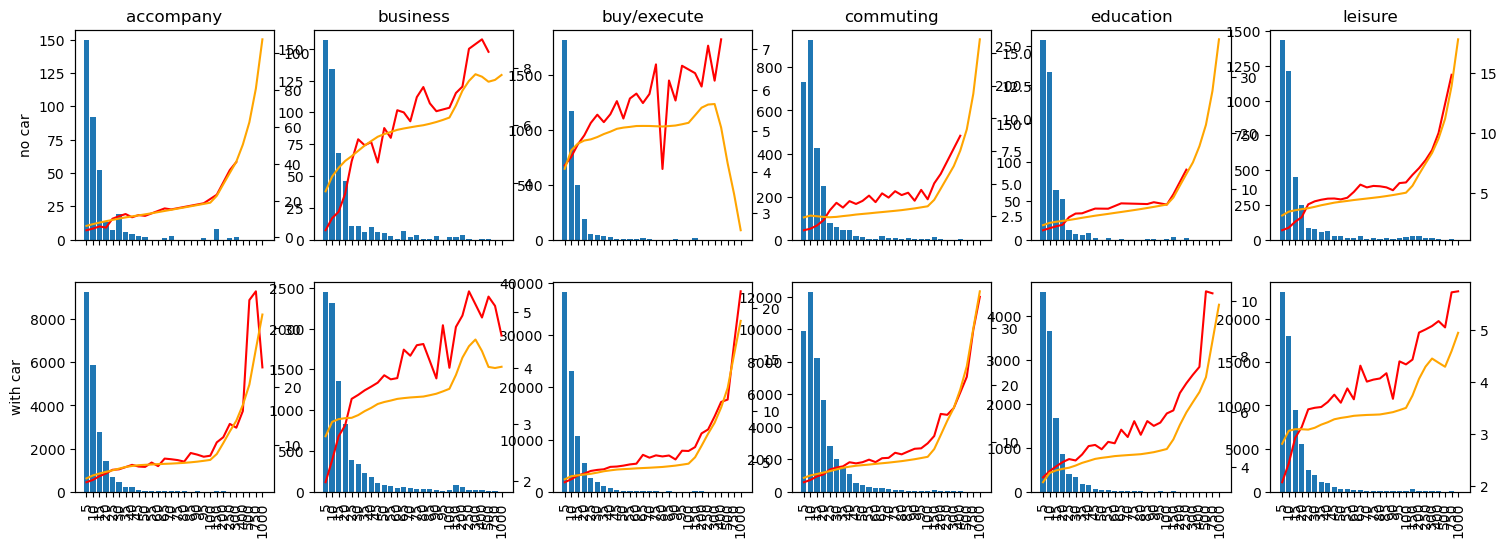

In [15]:
# Show number of trips and CC
fig, ax = plt.subplots(nrows=2, ncols=len(purposes), figsize=(18,6), sharex='all', sharey=False)
ind = pd.Series(np.arange(len(bins[1:])), bins[1:])
for i in [0,1]:
    for j in range(len(purposes)):
        mask = (trips['car_avail']==i) & (trips['purpose_model']==purposes[j])
        n_trips = trips.loc[mask, 'bin'].value_counts().sort_index()
        ax[i,j].bar(ind.loc[n_trips.index], n_trips)
        ax[i,j].set_xticks(ind, bins[1:], rotation=90)
        ax2 = ax[i,j].twinx()
        ax2.plot(ind.loc[n_trips.index], trips.loc[mask].groupby('bin')['cc'].mean(), color='red')
        cc_means = cc.groupby('bin')[purposes[j]+{0: '_no_car', 1: '_car'}[i]].mean()
        ax2.plot(ind.loc[cc_means.index], cc_means, color='orange')
        ax2.set_xticks(ind, bins[1:], rotation=90)
        ax[0,j].set_title(purposes[j])
ax[0,0].set_ylabel('no car')
ax[1,0].set_ylabel('with car')

Text(0, 0.5, 'with car')

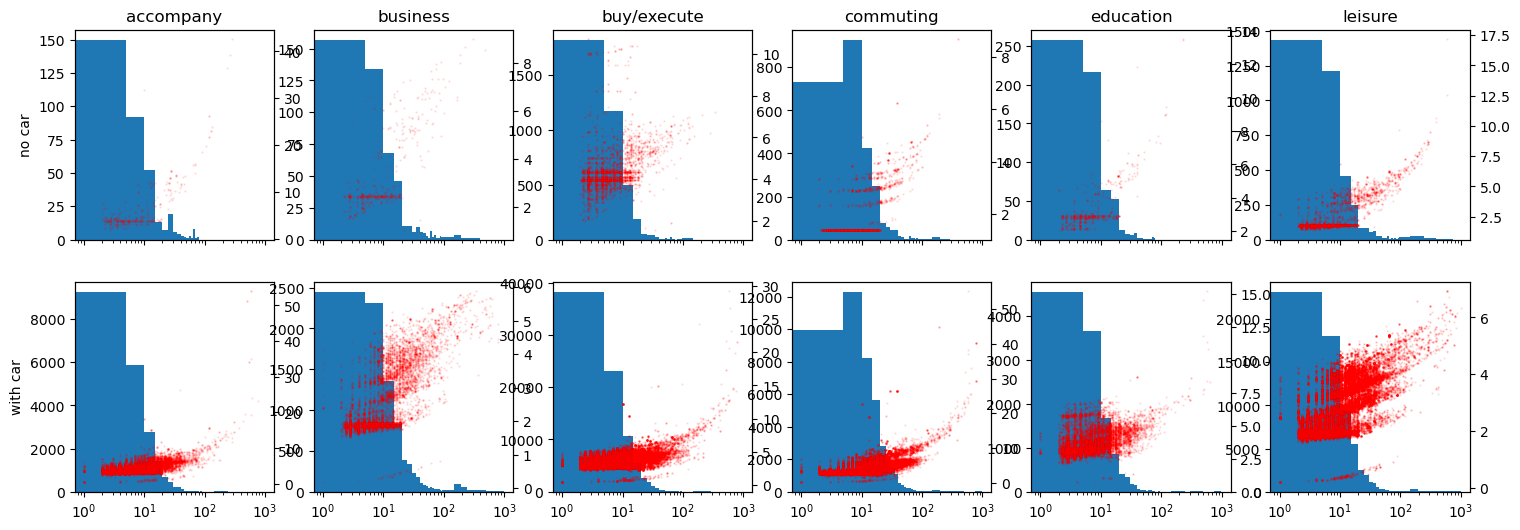

In [16]:
# Show number of trips and CC
fig, ax = plt.subplots(nrows=2, ncols=len(purposes), figsize=(18,6), sharex='all', sharey=False)
widths = [bins[dist]-bins[dist-1] for dist in range(2, len(bins))] + [0]
for i in [0,1]:
    for j in range(len(purposes)):
        mask = (trips['car_avail']==i) & (trips['purpose_model']==purposes[j])
        n_trips = trips.loc[mask, 'bin'].value_counts().sort_index()
        ax[i,j].bar([bins[1:][n] + widths[n]/2 -bins[1] for n in range(len(n_trips))], n_trips, width=widths[:len(n_trips)])
        ax[i,j].set_xscale('log')
        ax2 = ax[i,j].twinx()
        ax2.scatter(trips.loc[mask, 'length'], trips.loc[mask, 'cc'], s=.5, c='red', alpha=.1)
        ax2.set_xscale('log')
        ax[0,j].set_title(purposes[j])
ax[0,0].set_ylabel('no car')
ax[1,0].set_ylabel('with car')

## Estimation

In [17]:
# Define mathematical formulations for the cost term
def power_function(CC_D, a, b, c):
    cc, dist = CC_D
    return a * np.power(cc*c + dist*(1-c), -b)
def exponential_function(CC_D, a, b, c):
    cc, dist = CC_D
    return a * np.exp(-b * (cc*c + dist*(1-c)))
def lognormal_function(CC_D, a, b, c):
    cc, dist = CC_D
    return a * np.exp(-b * np.power(np.log(cc*c + dist*(1-c) + 1), 2))
functions = [power_function, exponential_function, lognormal_function]

In [18]:
def get_r_square(observations, fitted_values):
    mean_observation = np.mean(observations)
    ss_total = np.sum((observations - mean_observation) ** 2)
    ss_residual = np.sum((observations - fitted_values) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

In [39]:
# Define equally distributed bins for estimation
bins_eq = list(range(0, 1005, 5))
dist_means_eq = [2.5]+[bins_eq[i] + (bins_eq[i+1]-bins_eq[i])/2 for i in range(1, len(bins_eq[:-1]))]
trips['bin_eq'] = pd.cut(trips['length'].clip(lower=0.1), bins=bins_eq, labels=bins_eq[1:]).astype(int)
cc['bin_eq'] = pd.cut(cc['length'].clip(lower=0.1), bins=bins_eq, labels=bins_eq[1:]).astype(int)

In [40]:
# Estimate parameters
results = pd.DataFrame(columns=['segment', 'function', 'a', 'b', 'c', 'R2'])
for seg in segments:
    mask = trips['segment']==seg
    n_trips = trips.loc[mask, 'bin_eq'].value_counts()
    n_trips = pd.concat([n_trips, pd.Series(0, list(set(bins_eq[1:])-set(n_trips.index)))]).sort_index()
    #cc_means = trips.loc[mask].groupby('bin_eq')['cc'].mean()
    cc_means = cc.groupby('bin_eq')[seg].mean()
    CC = (np.array(cc_means), np.array(dist_means_eq))
    for f in functions:
        (a,b,c), _ = curve_fit(f, CC, n_trips,
                               p0=[1000., 1., 0.1],
                               bounds=(0, [1000000., 10., 1.]),
                               maxfev=10000)
        R2 = get_r_square(n_trips, f(CC, a,b,c))
        results.loc[len(results)] = [seg, f.__name__, a, b, c, R2]
results.set_index(['segment', 'function'], drop=True, inplace=True)

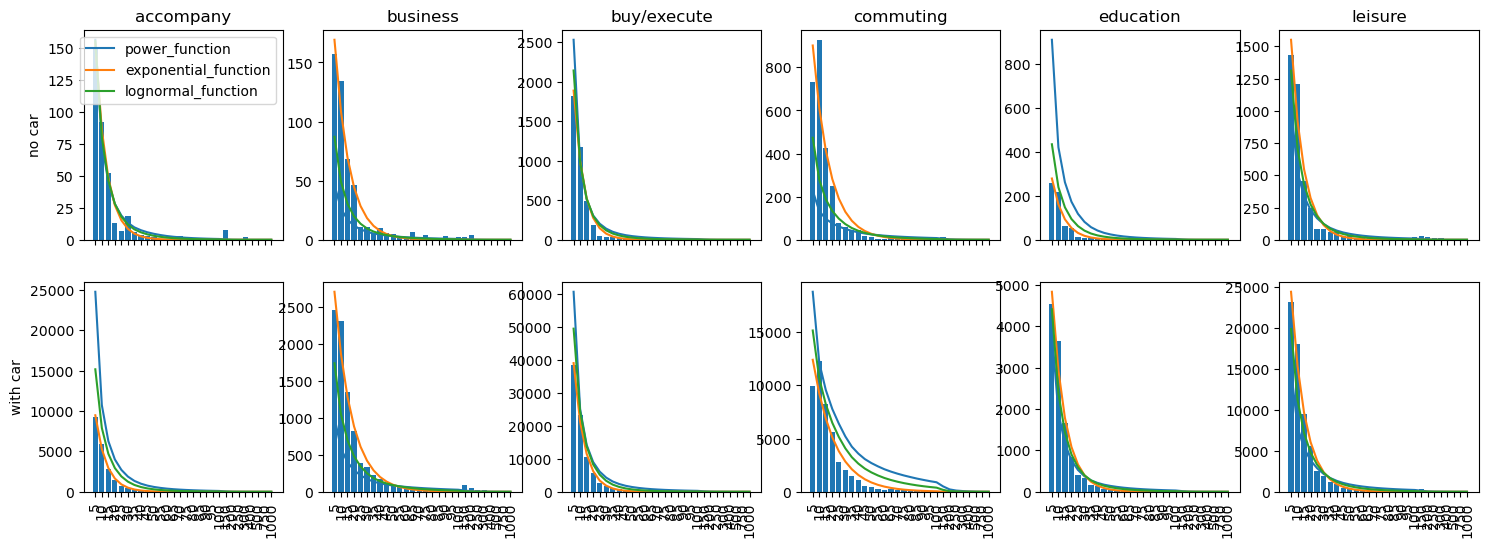

In [42]:
# Results for distance bins
fig, ax = plt.subplots(nrows=2, ncols=len(purposes), figsize=(18,6), sharex='all', sharey=False)
ind = pd.Series(np.arange(len(bins[1:])), bins[1:])
dist_means = [2.5]+[bins[i] + (bins[i+1]-bins[i])/2 for i in range(1, len(bins[:-1]))]
for i in [0,1]:
    for j in range(len(purposes)):
        mask = (trips['car_avail']==i) & (trips['purpose_model']==purposes[j])
        n_trips = trips.loc[mask, 'bin'].value_counts().sort_index()
        #cc_means = trips.loc[mask].groupby('bin')['cc'].mean()
        cc_means = cc.groupby('bin')[seg].mean()
        CC = (np.array(cc_means), np.array(dist_means))
        ax[i,j].bar(ind.loc[n_trips.index], n_trips)
        for f in functions:
            seg = purposes[j]+{0:'_no_car',1:'_car'}[i]
            ax[i,j].plot(ind.loc[cc_means.index],
                         f(CC, results.loc[(seg, f.__name__), 'a'],
                           results.loc[(seg, f.__name__), 'b'],
                           results.loc[(seg, f.__name__), 'c']),
                         label=f.__name__)
        ax[i,j].set_xticks(ind.values, bins[1:], rotation=90)
        ax[0,j].set_title(purposes[j])
ax[0,0].set_ylabel('no car')
ax[1,0].set_ylabel('with car')
ax[0,0].legend()

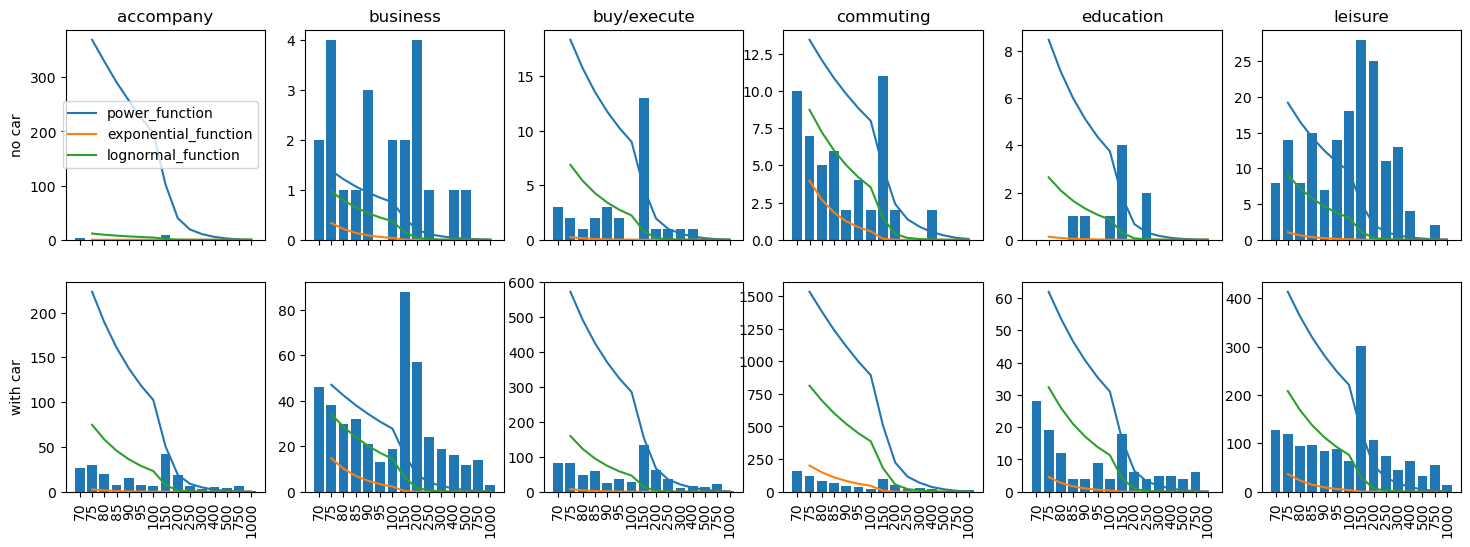

In [43]:
# Results for long-distance bins
fig, ax = plt.subplots(nrows=2, ncols=len(purposes), figsize=(18,6), sharex='all', sharey=False)
ind = pd.Series(np.arange(len(bins[1:])), bins[1:]).loc[bins[int(len(bins)/2):]]
for i in [0,1]:
    for j in range(len(purposes)):
        mask = (trips['car_avail']==i) & (trips['purpose_model']==purposes[j])
        n_trips = trips.loc[mask, 'bin'].value_counts().sort_index()
        #cc_means = trips.loc[mask].groupby('bin')['cc'].mean()
        cc_means = cc.groupby('bin')[seg].mean()
        n_trips = n_trips.loc[bins[int(len(bins)/2)]:]
        CC = (np.array(cc_means[int(len(bins)/2):]),
              np.array(dist_means[int(len(bins)/2):]))
        ax[i,j].bar(ind.loc[n_trips.index], n_trips)
        for f in functions:
            seg = purposes[j]+{0:'_no_car',1:'_car'}[i]
            ax[i,j].plot(ind.loc[cc_means[int(len(bins)/2):].index],
                         f(CC, results.loc[(seg, f.__name__), 'a'],
                           results.loc[(seg, f.__name__), 'b'],
                           results.loc[(seg, f.__name__), 'c']),
                         label=f.__name__)
        ax[i,j].set_xticks(ind.values, bins[int(len(bins)/2):], rotation=90)
        ax[0,j].set_title(purposes[j])
ax[0,0].set_ylabel('no car')
ax[1,0].set_ylabel('with car')
ax[0,0].legend()

In [44]:
results

a         b  \
segment            function                                         
accompany_car      power_function        1000000.000000  3.343176   
                   exponential_function    12691.009463  0.116872   
                   lognormal_function      65565.650952  0.770049   
accompany_no_car   power_function         598524.271178  4.534804   
                   exponential_function      204.863309  0.115521   
                   lognormal_function       3122.089935  0.821842   
business_car       power_function          43395.638043  2.692769   
                   exponential_function     3255.776885  0.074469   
                   lognormal_function       7839.589109  0.600782   
business_no_car    power_function           5228.735136  2.673726   
                   exponential_function      211.286500  0.088903   
                   lognormal_function        586.252521  0.555000   
buy/execute_car    power_function        1000000.000000  2.779713   
                   exponential_function    52875.384590  0.121950   
                   lognormal_function     190215.914157  0.780256   
buy/execute_no_car power_function         120593.559428  3.090428   
                   exponential_function     2599.612190  0.127761   
                   lognormal_function       8428.570963  0.640538   
commuting_car      power_function         734467.071933  3.079602   
                   exponential_function    14371.385636  0.058933   
                   lognormal_function      59976.574552  0.660337   
commuting_no_car   power_function          11413.637437  2.847593   
                   exponential_function     1094.235996  0.077512   
                   lognormal_function       2602.428995  0.690872   
education_car      power_function         177445.641487  2.977067   
                   exponential_function     6204.407989  0.099588   
                   lognormal_function      18233.032628  0.634588   
education_no_car   power_function          15943.752662  3.222620   
                   exponential_function      365.868116  0.109653   
                   lognormal_function       1228.633523  0.681519   
leisure_car        power_function         487847.499406  2.895264   
                   exponential_function    30792.001498  0.092825   
                   lognormal_function      78782.823137  0.660689   
leisure_no_car     power_function          41076.535942  2.942616   
                   exponential_function     2014.140915  0.104382   
                   lognormal_function       5341.932260  0.649372   

                                                    c        R2  
segment            function                                      
accompany_car      power_function        8.853311e-01  0.976690  
                   exponential_function  1.606150e-13  0.995947  
                   lognormal_function    7.960789e-01  0.987982  
accompany_no_car   power_function        9.749697e-01  0.972799  
                   exponential_function  3.407623e-14  0.984611  
                   lognormal_function    8.663393e-01  0.978762  
business_car       power_function        9.115569e-01  0.930213  
                   exponential_function  1.210034e-16  0.975517  
                   lognormal_function    8.105028e-01  0.957967  
business_no_car    power_function        8.916197e-01  0.931115  
                   exponential_function  2.140422e-12  0.973446  
                   lognormal_function    7.666375e-01  0.955566  
buy/execute_car    power_function        8.380094e-01  0.978322  
                   exponential_function  1.603310e-14  0.996981  
                   lognormal_function    7.702691e-01  0.990473  
buy/execute_no_car power_function        8.310953e-01  0.958007  
                   exponential_function  9.638033e-15  0.988816  
                   lognormal_function    6.837629e-01  0.974844  
commuting_car      power_function        9.568507e-01  0.881848  
                   exponential_function  2.71

In [45]:
# Save results
results.to_csv(input_path + 'estimation_results_distribution.csv')

## Inner-zonal distances

segment
accompany_car         Axes(0.125,0.11;0.775x0.77)
accompany_no_car      Axes(0.125,0.11;0.775x0.77)
business_car          Axes(0.125,0.11;0.775x0.77)
business_no_car       Axes(0.125,0.11;0.775x0.77)
buy/execute_car       Axes(0.125,0.11;0.775x0.77)
buy/execute_no_car    Axes(0.125,0.11;0.775x0.77)
commuting_car         Axes(0.125,0.11;0.775x0.77)
commuting_no_car      Axes(0.125,0.11;0.775x0.77)
education_car         Axes(0.125,0.11;0.775x0.77)
education_no_car      Axes(0.125,0.11;0.775x0.77)
leisure_car           Axes(0.125,0.11;0.775x0.77)
leisure_no_car        Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

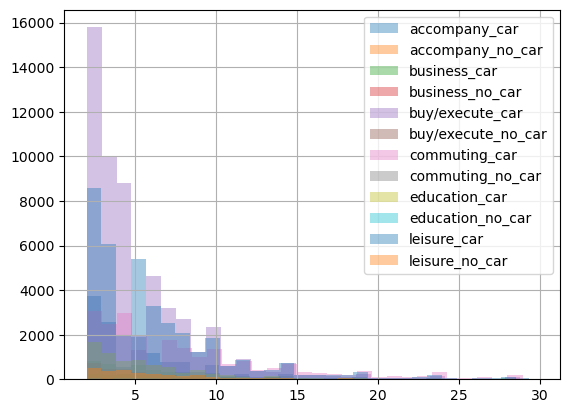

In [29]:
# Distance distribution of inner-zonal trips
trips.loc[trips['origin']==trips['destination']
         ].groupby('segment')['length'].hist(bins=30, alpha=.4, legend=True)

In [33]:
trips.loc[trips['origin']==trips['destination']
         ].groupby('segment')['length'].mean()

segment
accompany_car         5.657834
accompany_no_car      6.435424
business_car          7.322597
business_no_car       7.872050
buy/execute_car       5.389849
buy/execute_no_car    6.193252
commuting_car         8.194012
commuting_no_car      8.247224
education_car         6.131394
education_no_car      6.441189
leisure_car           6.212798
leisure_no_car        6.814558
Name: length, dtype: float64